In [1]:
from nltk.corpus import brown
from tqdm.auto import tqdm
import pandas as pd 

In [2]:
def brown_to_df(brown):

    data = {
        'text' : [],
        'category' : []
    }

    for cat in tqdm(brown.categories()):
        for sent in brown.docs(categories=cat):
            data['text'].append(' '.join(sent))
            data['category'].append(cat)
    return pd.DataFrame(data)
    
def brown_preprocess_text(text):
    text = text.lower()
    text = text.replace("``", "")
    text = text.replace("''", "")
    text = text.replace("`", "")
    text = text.replace("'", "")
    return text



In [3]:
import sys 

sys.path.append('/Users/rt853/UoB-HICCS-2025/src')

from baseline_model import *
from sklearn.model_selection import train_test_split



In [10]:
config = {
    'data_path': '/Users/rt853/UoB-HICCS-2025/data/datasets/binary_datasets/brown/government_binary.csv',
    'aug_amount': 0.2,
    'label': '1-RAPPORT',  # 1-RAPPORT 2-NEGOTIATE 3-EMOTION 4-LOGIC 5-AUTHORITY, 6-SOCIAL, 7-PRESSURE,
    'classification_type': 'multiclass',  # binary
    'model_type': 4,  # 1: Logistic Regression, 2: SVC, 3: MLP, 4: XGBoost 5: Random Forest 6: Decision Tree
    'confidence_threshold': 0.4,
    'verbose': True,  # True, False
    'vectorizer_type': 'tfidf',  # tfidf, count
    'ngram_range': '(1,4)',  # (1,1), (1,2), (2,2)
    'model_output_path': None,
    'result_output_path': None,
    'dataset' : 'Brown',
    'apply_smote': None,
    'scaler': True,
    'label_method': 'confidence',
    'add_augmented': None, #'/Users/rt853/UoB-persuasion-detection/data/training_sets/augmented/augmented_df_1-RAPPORT.csv',
    'augmented': None,
}

In [14]:
df = pd.read_csv(config['data_path']).dropna()


In [15]:
from baseline_model.main import data_pipeline
from baseline_model.model import train_model
from baseline_model.evaluate import evaluate_model

train_x, train_y, train_df, test_df, vectorizer = data_pipeline(config)
train_df['sentence_len'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['sentence_len'] = test_df['text'].apply(lambda x: len(x.split()))
train_df.head()

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [12]:
cat2idx = {i : idx for idx, i in enumerate(sorted(train_y.unique()))}

train_y = train_y.map(cat2idx)
test_y = test_df['multiclass'].map(cat2idx)     

In [7]:
model = train_model(train_x, train_y, config)
print(model)

Pipeline(steps=[('smote', None), ('scaler', StandardScaler(with_mean=False)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_con

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import pickle


In [9]:
test_x = vectorizer.transform(test_df['text'])
preds = model.predict(test_x)

report = classification_report(
    test_y, preds, output_dict=False,
    target_names=sorted(train_df.multiclass.unique()), zero_division=0)

print(report)

              precision    recall  f1-score   support

  government       1.00      1.00      1.00       279

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



In [30]:
top_categories = [cat2idx[i] for i in train_df['multiclass'].value_counts().head(10).keys().tolist()]

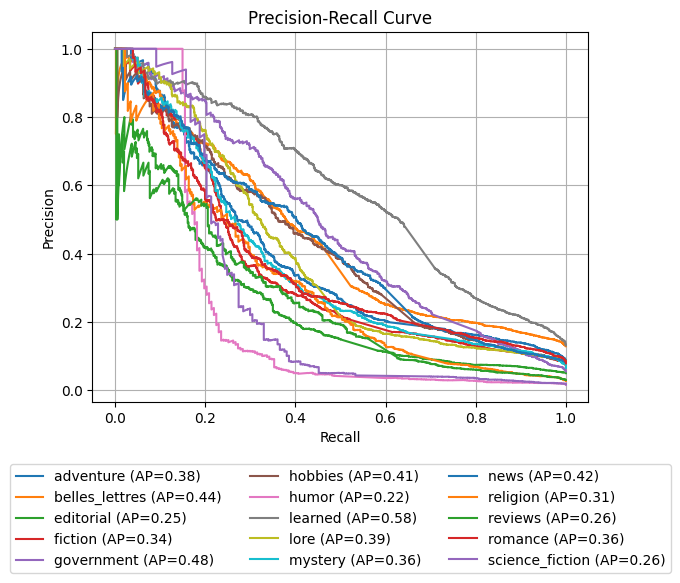

In [35]:
from sklearn.metrics import precision_recall_curve, average_precision_score


import matplotlib.pyplot as plt

# Get the predicted probabilities for each class
probs = model.predict_proba(test_x)

# Compute PR curve and average precision for each class
for i, class_name in enumerate(sorted(cat2idx.keys())):
    precision, recall, _ = precision_recall_curve(test_y == i, probs[:, i])
    avg_precision = average_precision_score(test_y == i, probs[:, i])
    
    plt.plot(recall, precision, label=f'{class_name} (AP={avg_precision:.2f})')

# Plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)  # Adjusted bbox_to_anchor to move the legend down
plt.grid()
plt.savefig('Brown_pr_curve.png', bbox_inches='tight', dpi=300)
plt.show()


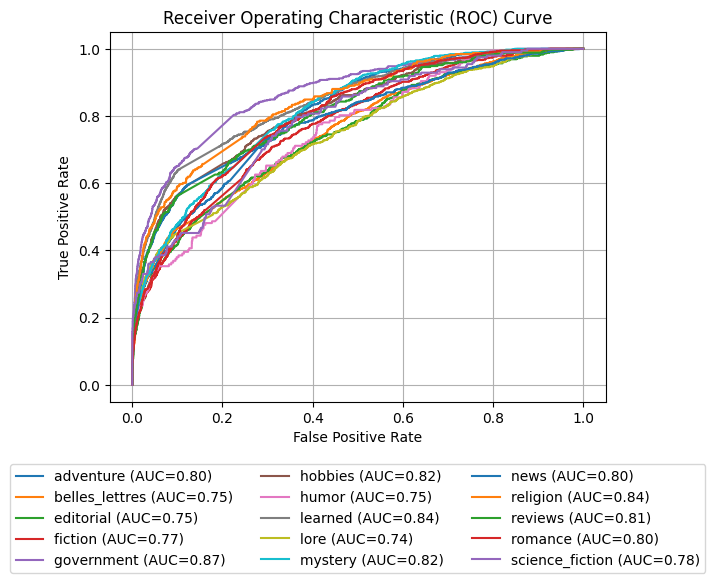

In [36]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for each class
for i, class_name in enumerate(sorted(cat2idx.keys())):
    fpr, tpr, _ = roc_curve(test_y == i, probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{class_name} (AUC={roc_auc:.2f})')

# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)  # Adjusted bbox_to_anchor to move the legend down
plt.grid()
plt.savefig('Brown_auroc_curve.png', bbox_inches='tight', dpi=300)
plt.show()
